# Project 3: Web APIs & NLP

## Notebook #2: Data Cleaning and Exploratory Data Analysis 

### Data Cleaning

In [1]:
# Importing Libraries for Data Cleaning and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
# Reading in CSVs that we created during our data collection phase
mcfc = pd.read_csv('./data/mcfc.csv')
reddevils = pd.read_csv('./data/reddevils.csv')

In [3]:
# Viewing first 5 rows for mcfc dataframe
mcfc.head()

,Unnamed: 0,title,author,created_utc,subreddit,selftext
0,0.0,Grealish should be joining within the week,jeremyparnaby,1627180473,MCFC,Kane is still up in the air. Plan B on a strik...
1,1.0,How many of them can you name?,UneducatedSlob,1627167486,MCFC,NaN
2,2.0,"Awww shit, here we go again: [Nick Harris] Whe...",_conjohn,1627166044,MCFC,NaN
3,3.0,[Daily Discussion] Saturday 24 July 2021,AutoModerator,1627160414,MCFC,This thread is for general discussion and a pl...
4,4.0,On this day 10 years ago,tquad24,1627152595,MCFC,NaN


In [4]:
# Viewing first 5 rows for reddevils dataframe
reddevils.head()

,Unnamed: 0,title,author,created_utc,subreddit,selftext
0,0.0,[Transfer Round Up and Discussion] Summer 2021,AutoModerator,1627178414,reddevils,Hello!\n\n&amp;#x200B;\n\nWelcome to Summer 20...
1,1.0,[GUARDIAN] Solskjær now has his own Manchester...,agent619,1627178338,reddevils,NaN
2,2.0,Mason Greenwood likes a post from Harry Pinero...,Dont_Eat_Apples,1627169698,reddevils,NaN
3,3.0,Ole Gunnar solskjaer In or out,BoxAny8377,1627160971,reddevils,NaN
4,4.0,Highlights | QPR 4-2 Manchester United | Linga...,AlexMerit,1627159369,reddevils,NaN


In [5]:
# Checking shape of each dataframe
print(f'mcfc dataframe shape: {mcfc.shape}')
print(f'We collected {mcfc.shape[0]} posts from the mcfc subreddit via web scraping using the PushShift API.\n')
print(f'reddevils dataframe shape: {reddevils.shape}')
print(f'We collected {reddevils.shape[0]} posts from the reddevils subreddit via web scraping using the PushShift API.')

mcfc dataframe shape: (50056, 6)
We collected 50056 posts from the mcfc subreddit via web scraping using the PushShift API.

reddevils dataframe shape: (50100, 6)
We collected 50100 posts from the reddevils subreddit via web scraping using the PushShift API.


In [6]:
# Dropping 'Unnamed: 0' column in both dataframes
mcfc.drop('Unnamed: 0', axis=1, inplace=True)
reddevils.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
# Converting 'created_utc' unix time entries into date and time entries and creating a 'created' column
# Inspiration for the below code was taken from Stackoverflow:
# https://stackoverflow.com/questions/48416511/how-to-convert-utc-to-est-with-python-and-take-care-of-daylight-saving-automatic

mcfc['created'] = mcfc['created_utc'].apply(dt.datetime.fromtimestamp)
reddevils['created'] = reddevils['created_utc'].apply(dt.datetime.fromtimestamp)

In [8]:
# After creating a new 'created' column with the date in a more understandable format,
# I will print the earliest post and latest post dates for each dataframe

# The results will follow in next cell.
print(f"Earliest post for mcfc: {mcfc['created'].min()}")
print(f"Most recent post for mcfc: {mcfc['created'].max()}\n")
print(f"Earliest post for reddevils: {reddevils['created'].min()}")
print(f"Most recent post for reddevils: {reddevils['created'].max()}")

Earliest post for mcfc: 2016-02-12 08:12:26
Most recent post for mcfc: 2021-07-24 22:34:33

Earliest post for reddevils: 2019-10-21 04:15:09
Most recent post for reddevils: 2021-07-24 22:00:14


In [9]:
# Given the above output, we can summarize that the earliest post was in February 2016, 
# and the most recent post was on July 24, 2021. (This makes sense because I collected the data on July 24)

# I will create a new categorical variable column titled 'year'. 

# Inspiration for the dt.year was taken from the below
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.year.html
mcfc['year'] = mcfc['created'].dt.year
reddevils['year'] = reddevils['created'].dt.year

In [10]:
# For some background information, the English Premier League (the football league that both Manchester City
# and Manchester United play in) generally has their season between August - May of the following year.
# e.g. The upcoming 2021-2022 season is scheduled to begin on August 13, 2021 and end on May 22, 2022.

# An interesting assessment would be to categorize 'created' column dates into 'season.'
# Then, we'd in theory be able to make some assessments on which season had the most activity in the subreddits.

# However, I decided to omit this for the purposes of this project because there are too many variables in this assessment.
# e.g. A season only lasts from August - May. In this case, are posts between June - July of a given year in relation to the previous season
# or the upcoming one? Perhaps one of the teams had a successful run during a season and kept the fans excited for months, but the other team had
# an exciting new player signed for the upcoming season.

# Because of this, for the purposes of this project, I've decided to omit this level of exploration, as I'd like to focus on classification techniques.

# However, because I found the use of datatime.strptime() very interesting in comparing datetime types, I leave some preliminary code here.
# Inspiration taken from the below 2 links:
# 1. https://docs.python.org/3/library/datetime.html
# 2. https://www.tutorialspoint.com/python/time_strptime.htm

#def epl_season(n):
#     if n > dt.datetime.strptime('2022-05-22 23:59:59', '%Y-%m-%d %H:%M:%S'):
#         season = 'Post 2021-2022 Offseason'
#     elif (n <= dt.datetime.strptime('2022-05-22 23:59:59', '%Y-%m-%d %H:%M:%S')) & (n > dt.datetime.strptime('2021-08-13 00:00:00', '%Y-%m-%d %H:%M:%S')):
#         season = '2020-2021'
#     return season

In [11]:
# From Wikipedia, I gathered the final standings of both Manchester City and Manchester United in the English Premier League from the 2015-2016
# season to the 2020-2021 seasons. For simplicity, I will link the calendar year to the final standing.

# e.g. Manchester City finished 4th in the 2015-2016 season. I will consider their 2016 standing to be 4th.

# Creating a dictionary with key = year and value = final standing
mcfc_season_record_dict = {2016: 4, 2017: 3, 2018: 1, 2019: 1, 2020: 2, 2021: 1}
reddevils_season_record_dict = {2016: 5, 2017: 6, 2018: 2, 2019: 6, 2020: 3, 2021: 2}

# Sources: https://en.wikipedia.org/wiki/List_of_Manchester_City_F.C._seasons
# https://en.wikipedia.org/wiki/List_of_Manchester_United_F.C._seasons

In [12]:
# I will map the above dictionaries to the 'year' column to create a new 'season_standings'column.
# This is the reason why I continued to work with individual dataframes rather than concatenate one large dataframe - 
# to successfully map standings for each club separately

mcfc['season_standings'] = mcfc['year'].map(mcfc_season_record_dict)
reddevils['season_standings'] = reddevils['year'].map(reddevils_season_record_dict)

In [13]:
# I will now combine each dataframe into a single dataframe
submissions = pd.concat([mcfc, reddevils])

In [14]:
# I'd like to revise the standings data so that it'd be easier to visualize in a plot.

# The logic I'd like to use is as follows:
# If you are 1st place in a league of 20 teams, you are essentially the highest ranked team. Translating this into simple counting, the largest number from 1 - 20
# is 20. Therefore, I would like to map a new column to reflect this.
# e.g. 1st place -> 20; 2nd place -> 19, 3rd place -> 18, ...., 18th place -> 3, 19th place -> 2, 20th place -> 1

season_standings_to_plot = {1:20, 2:19, 3:18, 4:17, 5:16, 6:15, 7:14, 8:13, 9:12, 10:11, 11:10, 12:9, 13:8, 14:7, 15:6, 16:5, 17:4, 18:3, 19:2, 20:1, 'TBD': 'TBD'}
submissions['season_standings_to_plot'] = submissions['season_standings'].map(season_standings_to_plot)

In [15]:
# Checking for null values
submissions.isnull().sum()

title                           0
author                          0
created_utc                     0
subreddit                       0
selftext                    69301
created                         0
year                            0
season_standings                0
season_standings_to_plot        0
dtype: int64

In [16]:
# The null values in the 'selftext' columns are blank entries.
# I will therefore remove these by replacing them with an empty string.
submissions = submissions.replace(np.nan, '')

In [17]:
# Checking for null values
submissions.isnull().sum()

title                       0
author                      0
created_utc                 0
subreddit                   0
selftext                    0
created                     0
year                        0
season_standings            0
season_standings_to_plot    0
dtype: int64

In [18]:
# I will take a look at value counts for the 'selftext' column.
submissions['selftext'].value_counts()

In [19]:
# From the above, we can see that the most recurring entries are '[removed]' and '[deleted]'.
# Therefore, I will replace these entries with empty strings as well.

submissions['selftext'].replace('[deleted]', '', inplace=True)
submissions['selftext'].replace('[removed]', '', inplace=True)

In [20]:
# A second attempt at value count. It seems there were 69301 null values (empty strings) + 4661 [removed] and 3992 [deleted] for a total of 77954 'selftext'
# columns set to an empty string.
submissions['selftext'].value_counts()

In [21]:
# It seems like a lot of recurring posts are to remind the community of the general guidelines of the subreddit and to refrain from toxic and abusive posts.

In [22]:
# Because we are dealing with the submissions data, it is not entirely surprising to see a lot of empty 'selftext' entries.
# I will create a combined 'title_selftext' column that will capture both the content from the 'title' and 'selftext' columns into one column.
submissions['title_selftext'] = submissions['title'] + ': ' + submissions['selftext']

In [23]:
# Viewing current dataframe
submissions.head()

,title,author,created_utc,subreddit,selftext,created,year,season_standings,season_standings_to_plot,title_selftext
0,Grealish should be joining within the week,jeremyparnaby,1627180473,MCFC,Kane is still up in the air. Plan B on a strik...,2021-07-24 22:34:33,2021,1,20,Grealish should be joining within the week: Ka...
1,How many of them can you name?,UneducatedSlob,1627167486,MCFC,,2021-07-24 18:58:06,2021,1,20,How many of them can you name?:
2,"Awww shit, here we go again: [Nick Harris] Whe...",_conjohn,1627166044,MCFC,,2021-07-24 18:34:04,2021,1,20,"Awww shit, here we go again: [Nick Harris] Whe..."
3,[Daily Discussion] Saturday 24 July 2021,AutoModerator,1627160414,MCFC,This thread is for general discussion and a pl...,2021-07-24 17:00:14,2021,1,20,[Daily Discussion] Saturday 24 July 2021: This...
4,On this day 10 years ago,tquad24,1627152595,MCFC,,2021-07-24 14:49:55,2021,1,20,On this day 10 years ago:


In [24]:
# From initial EDA, I noticed that components of website links appeared in frequent words found in posts (e.g. https, www)
# Therefore, I'd like to remove url strings from the title_selftext column.

# Inspiration from Stack Overflow: https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105

def remove_url(string):
    return re.sub(r'http\S+', '', string)

In [25]:
submissions['title_selftext'] = submissions['title_selftext'].apply(remove_url)

In [26]:
# Dropping unnecessary columns
submissions = submissions.drop(columns=['title', 'created_utc', 'selftext'])

In [27]:
# Reorganizing columns
submissions = submissions[['author', 'title_selftext', 'created', 'year', 'season_standings', 'season_standings_to_plot', 'subreddit']]

In [28]:
# Binarizing subreddit classifications: MCFC to 1, reddevils to 0
submissions['subreddit'] = submissions['subreddit'].map({'MCFC': 1, 'reddevils': 0})

In [29]:
# To show first and last 5 rows of dataframe
submissions

,author,title_selftext,created,year,season_standings,season_standings_to_plot,subreddit
0,jeremyparnaby,Grealish should be joining within the week: Ka...,2021-07-24 22:34:33,2021,1,20,1
1,UneducatedSlob,How many of them can you name?:,2021-07-24 18:58:06,2021,1,20,1
2,_conjohn,"Awww shit, here we go again: [Nick Harris] Whe...",2021-07-24 18:34:04,2021,1,20,1
3,AutoModerator,[Daily Discussion] Saturday 24 July 2021: This...,2021-07-24 17:00:14,2021,1,20,1
4,tquad24,On this day 10 years ago:,2021-07-24 14:49:55,2021,1,20,1
...,...,...,...,...,...,...,...
50095,neotahiro,Three at the back and two up front shows Solsk...,2019-10-21 04:47:41,2019,6,15,0
50096,Poopy_Butt_Seed,Ole hints new formation could stay:,2019-10-21 04:40:45,2019,6,15,0
50097,ashu54,Ole Gunnar Solskjaer gives injury update after...,2019-10-21 04:39:30,2019,6,15,0
50098,IPassedTheRobotTest,Is this news about the Saudi's buying Man Unit...,2019-10-21 04:33:28,2019,6,15,0


In [30]:
# Confirming datatypes of each column
submissions.dtypes

author                              object
title_selftext                      object
created                     datetime64[ns]
year                                 int64
season_standings                     int64
season_standings_to_plot             int64
subreddit                            int64
dtype: object

In [31]:
# Value counts - consistent with our initial data collection: 50,100 reddevils posts and 50,056 MCFC posts collected
submissions['subreddit'].value_counts()

0    50100
1    50056
Name: subreddit, dtype: int64

In [32]:
# I realize that reddit posts can at times have posts with less than ideal tone and language.

# For future reference, I'd like to leave this link readily available for implementing a library to sensor profanity.
# https://www.geeksforgeeks.org/censor-bad-words-in-python-using-better-profanity/

In [33]:
# Grouping reddit posts by subreddit and year
submissions.groupby(['subreddit', 'year'])['title_selftext'].count()

subreddit  year
0          2019     5685
           2020    30967
           2021    13448
1          2016     5911
           2017     9822
           2018     9191
           2019     9718
           2020     9289
           2021     6125
Name: title_selftext, dtype: int64

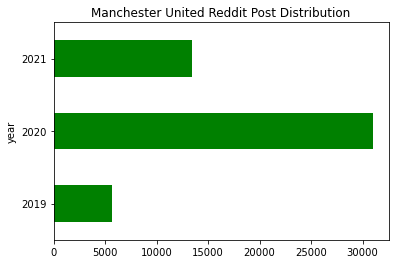

In [34]:
# Let's visualize the above.
submissions_reddevils = submissions[submissions['subreddit'] == 0]
submissions_mcfc = submissions[submissions['subreddit'] == 1]

submissions_reddevils.groupby('year')['title_selftext'].count().plot(kind='barh', color='green')
plt.title('Manchester United Reddit Post Distribution');

In [35]:
# Considering that our posts collected started from October 2019 to July 2021, we only have one full year's worth of posts 
# for the reddevils reddit.

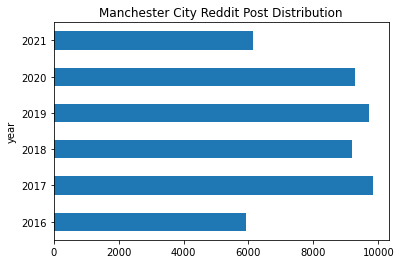

In [36]:
submissions_mcfc.groupby('year')['title_selftext'].count().plot(kind='barh');
plt.title('Manchester City Reddit Post Distribution');

In [37]:
# The posts for Manchester City were collected from February 2016 to July 2021. Therefore, if we take a look at the full years
# of 2017 - 2020, it looks to be relatively stable from a visual perspective.

In [38]:
# We saw this briefly when I obtained the earliest and most recent posts for both reddits. 
# I performed data collection for approximately 50,000  posts each.

# The Manchester City reddit shows a relative even distribution throughout 2016 - 2021.
# However, the reddevils reddit only spans from October 2019 - July 2021, less than half the period of Manchester City.

# This shows that the reddevils reddit is MUCH MORE active than the Manchester United reddit.

# This can be supported by the below link. As of June 2019, Manchester United (reddevils) had 164,276 subscribers,
# while Manchester City had 52,200 subscribers. The ratio of reddevils subscribers to Manchester City is greater than 3:1.
# https://www.reddit.com/r/soccer/comments/c1p61u/football_clubs_with_the_largest_subreddits_as_of/

# Therefore, given the data set, I don't think we'd be able to make really meaningful conclusions based on trends from year to year.
# For the purposes of this project, I will delete the 'year' and 'season_standings' / 'season_standings_to_post' columns.

submissions = submissions.drop(['year', 'season_standings', 'season_standings_to_plot'], axis=1)

In [39]:
submissions.dtypes

author                    object
title_selftext            object
created           datetime64[ns]
subreddit                  int64
dtype: object

In [40]:
submissions.rename({'title_selftext' : 'text'}, axis = 1, inplace=True)

In [41]:
submissions.head()

,author,text,created,subreddit
0,jeremyparnaby,Grealish should be joining within the week: Ka...,2021-07-24 22:34:33,1
1,UneducatedSlob,How many of them can you name?:,2021-07-24 18:58:06,1
2,_conjohn,"Awww shit, here we go again: [Nick Harris] Whe...",2021-07-24 18:34:04,1
3,AutoModerator,[Daily Discussion] Saturday 24 July 2021: This...,2021-07-24 17:00:14,1
4,tquad24,On this day 10 years ago:,2021-07-24 14:49:55,1


In [42]:
# Save Cleaned Dataframe to CSV
submissions.to_csv('./data/submissions_clean.csv')

### Exploratory Data Analysis (EDA)

#### Pre-Processing the Data (NLP)

##### Tokenize to separate list and remove punctuation

In [43]:
# Instantiate RegExp Tokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [44]:
# Apply RegExp Tokenizer to remove punctuation
submissions['text_tokenized'] = submissions['text'].apply(tokenizer.tokenize)

In [45]:
submissions.head()

,author,text,created,subreddit,text_tokenized
0,jeremyparnaby,Grealish should be joining within the week: Ka...,2021-07-24 22:34:33,1,"[Grealish, should, be, joining, within, the, w..."
1,UneducatedSlob,How many of them can you name?:,2021-07-24 18:58:06,1,"[How, many, of, them, can, you, name]"
2,_conjohn,"Awww shit, here we go again: [Nick Harris] Whe...",2021-07-24 18:34:04,1,"[Awww, shit, here, we, go, again, Nick, Harris..."
3,AutoModerator,[Daily Discussion] Saturday 24 July 2021: This...,2021-07-24 17:00:14,1,"[Daily, Discussion, Saturday, 24, July, 2021, ..."
4,tquad24,On this day 10 years ago:,2021-07-24 14:49:55,1,"[On, this, day, 10, years, ago]"


##### Lemmatize to capture and combine similar forms of the same words

In [46]:
# Instantiate lemmatizer. 
lemmatizer = WordNetLemmatizer()

In [47]:
# Apply Lemmatizer to tokenized text to capture and combine similar forms of the same words (e.g. run/ran)
submissions['text_lemmatized'] = submissions['text_tokenized'].apply(lambda x: ''.join(str(x))).apply(lemmatizer.lemmatize)

In [48]:
submissions.head()

,author,text,created,subreddit,text_tokenized,text_lemmatized
0,jeremyparnaby,Grealish should be joining within the week: Ka...,2021-07-24 22:34:33,1,"[Grealish, should, be, joining, within, the, w...","['Grealish', 'should', 'be', 'joining', 'withi..."
1,UneducatedSlob,How many of them can you name?:,2021-07-24 18:58:06,1,"[How, many, of, them, can, you, name]","['How', 'many', 'of', 'them', 'can', 'you', 'n..."
2,_conjohn,"Awww shit, here we go again: [Nick Harris] Whe...",2021-07-24 18:34:04,1,"[Awww, shit, here, we, go, again, Nick, Harris...","['Awww', 'shit', 'here', 'we', 'go', 'again', ..."
3,AutoModerator,[Daily Discussion] Saturday 24 July 2021: This...,2021-07-24 17:00:14,1,"[Daily, Discussion, Saturday, 24, July, 2021, ...","['Daily', 'Discussion', 'Saturday', '24', 'Jul..."
4,tquad24,On this day 10 years ago:,2021-07-24 14:49:55,1,"[On, this, day, 10, years, ago]","['On', 'this', 'day', '10', 'years', 'ago']"


##### Count Vectorize the lemmatized text

In [49]:
# Instantiate CountVectorizer object for reddevils
cvec_1 = CountVectorizer(stop_words='english')

In [50]:
submissions_reddevils = submissions[submissions['subreddit'] == 0]
X = submissions_reddevils['text_lemmatized'].apply(lambda x: ''.join(str(x)))

In [51]:
cvec_1.fit(X)

CountVectorizer(stop_words='english')

In [52]:
X = cvec_1.transform(X)

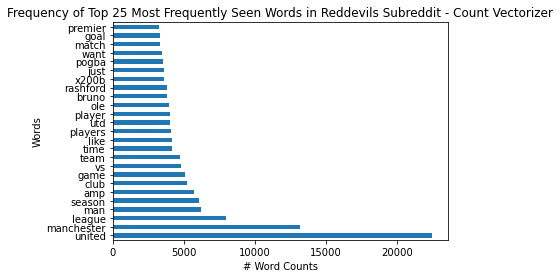

In [53]:
transformed_df = pd.DataFrame(X.todense(), columns = cvec_1.get_feature_names())

plt.figsize=(30,30)
plt.xlabel('# Word Counts')
plt.ylabel('Words')
plt.title('Frequency of Top 25 Most Frequently Seen Words in Reddevils Subreddit - Count Vectorizer')
transformed_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

In [54]:
top_25_words_reddevils_cvec = transformed_df.sum().sort_values(ascending=False)[0:25]
top_25_words_reddevils_cveclist = list(pd.DataFrame(top_25_words_reddevils_cvec).index.values)

In [55]:
# Instantiate CountVectorizer object for mcfc
cvec_2 = CountVectorizer(stop_words='english')

In [56]:
submissions_mcfc = submissions[submissions['subreddit'] == 1]
X = submissions_mcfc['text_lemmatized'].apply(lambda x: ''.join(str(x)))

In [57]:
cvec_2.fit(X)

CountVectorizer(stop_words='english')

In [58]:
X = cvec_2.transform(X)

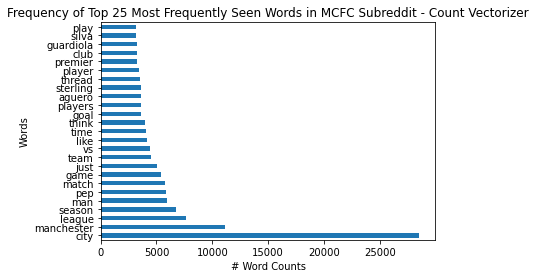

In [59]:
transformed_df = pd.DataFrame(X.todense(), columns = cvec_2.get_feature_names())

plt.figsize=(30,30)
plt.xlabel('# Word Counts')
plt.ylabel('Words')
plt.title('Frequency of Top 25 Most Frequently Seen Words in MCFC Subreddit - Count Vectorizer')
transformed_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

In [60]:
top_25_words_mcfc_cvec = transformed_df.sum().sort_values(ascending=False)[0:25]
top_25_words_mcfc_cveclist = list(pd.DataFrame(top_25_words_mcfc_cvec).index.values)

In [61]:
reddevils_unique_words_in_top_25_cvec = []
mcfc_unique_words_in_top_25_cvec = []

for k in top_25_words_reddevils_cveclist:
    if k not in top_25_words_mcfc_cveclist:
        reddevils_unique_words_in_top_25_cvec.append(k)

for j in top_25_words_mcfc_cveclist:
    if j not in top_25_words_reddevils_cveclist:
        mcfc_unique_words_in_top_25_cvec.append(j)

In [62]:
reddevils_unique_words_in_top_25_cvec

['united', 'amp', 'utd', 'ole', 'bruno', 'rashford', 'x200b', 'pogba', 'want']

In [63]:
mcfc_unique_words_in_top_25_cvec

['city',
 'pep',
 'think',
 'aguero',
 'sterling',
 'thread',
 'guardiola',
 'silva',
 'play']

In [64]:
# Instantiate CountVectorizer object for full dataframe
cvec_3 = CountVectorizer(stop_words='english')

In [65]:
X = submissions['text_lemmatized'].apply(lambda x: ''.join(str(x)))

In [66]:
cvec_3.fit(X)

CountVectorizer(stop_words='english')

In [67]:
X = cvec_3.transform(X)

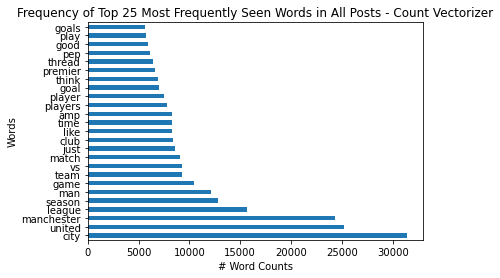

In [68]:
transformed_df = pd.DataFrame(X.todense(), columns = cvec_3.get_feature_names())

plt.figsize=(30,30)
plt.xlabel('# Word Counts')
plt.ylabel('Words')
plt.title('Frequency of Top 25 Most Frequently Seen Words in All Posts - Count Vectorizer')
transformed_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

In [69]:
top_25_words_reddevils_cveclist

['united',
 'manchester',
 'league',
 'man',
 'season',
 'amp',
 'club',
 'game',
 'vs',
 'team',
 'time',
 'like',
 'players',
 'utd',
 'player',
 'ole',
 'bruno',
 'rashford',
 'x200b',
 'just',
 'pogba',
 'want',
 'match',
 'goal',
 'premier']

In [70]:
top_25_words_mcfc_cveclist

['city',
 'manchester',
 'league',
 'season',
 'man',
 'pep',
 'match',
 'game',
 'just',
 'team',
 'vs',
 'like',
 'time',
 'think',
 'goal',
 'players',
 'aguero',
 'sterling',
 'thread',
 'player',
 'premier',
 'club',
 'guardiola',
 'silva',
 'play']

In [71]:
top_25_words_all_cvec = transformed_df.sum().sort_values(ascending=False)[0:25]
top_25_words_all_cveclist = list(pd.DataFrame(top_25_words_all_cvec).index.values)
top_25_words_all_cveclist

['city',
 'united',
 'manchester',
 'league',
 'season',
 'man',
 'game',
 'team',
 'vs',
 'match',
 'just',
 'club',
 'like',
 'time',
 'amp',
 'players',
 'player',
 'goal',
 'think',
 'premier',
 'thread',
 'pep',
 'good',
 'play',
 'goals']

##### Term Frequency-Inverse Document Frequency (TF-IDF) Vectorize the Lemmatized text

In [72]:
# Instantiate TFIDF Vectorizer object for reddevils
tvec_1 = TfidfVectorizer(stop_words='english')

In [73]:
submissions_reddevils = submissions[submissions['subreddit'] == 0]
X = submissions_reddevils['text_lemmatized'].apply(lambda x: ''.join(str(x)))

In [74]:
tvec_1.fit(X)

TfidfVectorizer(stop_words='english')

In [75]:
X = tvec_1.transform(X)

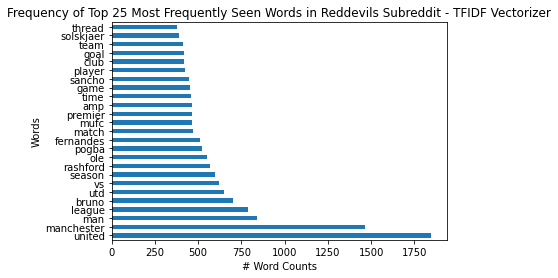

In [76]:
transformed_df = pd.DataFrame(X.todense(), columns = tvec_1.get_feature_names())

plt.figsize=(30,30)
plt.xlabel('# Word Counts')
plt.ylabel('Words')
plt.title('Frequency of Top 25 Most Frequently Seen Words in Reddevils Subreddit - TFIDF Vectorizer')
transformed_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

In [77]:
top_25_words_reddevils_tvec = transformed_df.sum().sort_values(ascending=False)[0:25]
top_25_words_reddevils_tveclist = list(pd.DataFrame(top_25_words_reddevils_tvec).index.values)

In [78]:
# Instantiate TFIDF Vectorizer object for mcfc
tvec_2 = TfidfVectorizer(stop_words='english')

In [79]:
submissions_mcfc = submissions[submissions['subreddit'] == 1]
X = submissions_mcfc['text_lemmatized'].apply(lambda x: ''.join(str(x)))

In [80]:
tvec_2.fit(X)

TfidfVectorizer(stop_words='english')

In [81]:
X = tvec_2.transform(X)

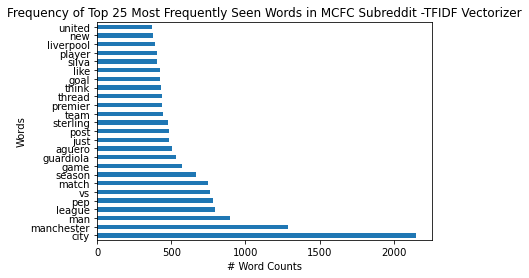

In [82]:
transformed_df = pd.DataFrame(X.todense(), columns = tvec_2.get_feature_names())

plt.figsize=(30,30)
plt.xlabel('# Word Counts')
plt.ylabel('Words')
plt.title('Frequency of Top 25 Most Frequently Seen Words in MCFC Subreddit -TFIDF Vectorizer')
transformed_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

In [83]:
top_25_words_mcfc_tvec = transformed_df.sum().sort_values(ascending=False)[0:25]
top_25_words_mcfc_tveclist = list(pd.DataFrame(top_25_words_mcfc_tvec).index.values)

In [84]:
reddevils_unique_words_in_top_25_tvec = []
mcfc_unique_words_in_top_25_tvec = []

for k in top_25_words_reddevils_tveclist:
    if k not in top_25_words_mcfc_tveclist:
        reddevils_unique_words_in_top_25_tvec.append(k)

for j in top_25_words_mcfc_tveclist:
    if j not in top_25_words_reddevils_tveclist:
        mcfc_unique_words_in_top_25_tvec.append(j)

In [85]:
reddevils_unique_words_in_top_25_tvec

['bruno',
 'utd',
 'rashford',
 'ole',
 'pogba',
 'fernandes',
 'mufc',
 'amp',
 'time',
 'sancho',
 'club',
 'solskjaer']

In [86]:
mcfc_unique_words_in_top_25_tvec

['city',
 'pep',
 'guardiola',
 'aguero',
 'just',
 'post',
 'sterling',
 'think',
 'like',
 'silva',
 'liverpool',
 'new']

In [87]:
# Instantiate TFIDF Vectorizer object for reddevils
tvec_3 = TfidfVectorizer(stop_words='english')

In [88]:
X = submissions['text_lemmatized'].apply(lambda x: ''.join(str(x)))

In [89]:
tvec_3.fit(X)

TfidfVectorizer(stop_words='english')

In [90]:
X = tvec_3.transform(X)

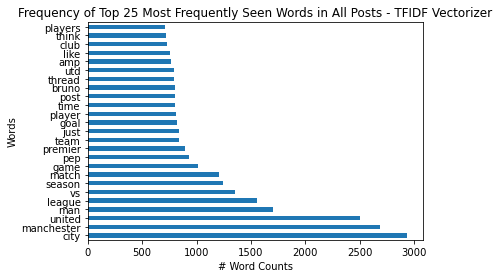

In [91]:
transformed_df = pd.DataFrame(X.todense(), columns = tvec_3.get_feature_names())

plt.figsize=(30,30)
plt.xlabel('# Word Counts')
plt.ylabel('Words')
plt.title('Frequency of Top 25 Most Frequently Seen Words in All Posts - TFIDF Vectorizer')
transformed_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

In [92]:
top_25_words_reddevils_tveclist

['united',
 'manchester',
 'man',
 'league',
 'bruno',
 'utd',
 'vs',
 'season',
 'rashford',
 'ole',
 'pogba',
 'fernandes',
 'match',
 'mufc',
 'premier',
 'amp',
 'time',
 'game',
 'sancho',
 'player',
 'club',
 'goal',
 'team',
 'solskjaer',
 'thread']

In [93]:
top_25_words_mcfc_tveclist

['city',
 'manchester',
 'man',
 'league',
 'pep',
 'vs',
 'match',
 'season',
 'game',
 'guardiola',
 'aguero',
 'just',
 'post',
 'sterling',
 'team',
 'premier',
 'thread',
 'think',
 'goal',
 'like',
 'silva',
 'player',
 'liverpool',
 'new',
 'united']

In [94]:
top_25_words_all_tveclist = list(pd.DataFrame(transformed_df.sum().sort_values(ascending=False).head(25)).index.values)
top_25_words_all_tveclist

['city',
 'manchester',
 'united',
 'man',
 'league',
 'vs',
 'season',
 'match',
 'game',
 'pep',
 'premier',
 'team',
 'just',
 'goal',
 'player',
 'time',
 'post',
 'bruno',
 'thread',
 'utd',
 'amp',
 'like',
 'club',
 'think',
 'players']

##### Sentiment Analysis

In [95]:
# Instantiate Sentiment Intensity Analyzer
sentiment = SentimentIntensityAnalyzer()

In [96]:
# Creating a column for sentiment
submissions['sentiment'] = submissions['text_lemmatized'].apply(sentiment.polarity_scores)

In [97]:
submissions.head()

,author,text,created,subreddit,text_tokenized,text_lemmatized,sentiment
0,jeremyparnaby,Grealish should be joining within the week: Ka...,2021-07-24 22:34:33,1,"[Grealish, should, be, joining, within, the, w...","['Grealish', 'should', 'be', 'joining', 'withi...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,UneducatedSlob,How many of them can you name?:,2021-07-24 18:58:06,1,"[How, many, of, them, can, you, name]","['How', 'many', 'of', 'them', 'can', 'you', 'n...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,_conjohn,"Awww shit, here we go again: [Nick Harris] Whe...",2021-07-24 18:34:04,1,"[Awww, shit, here, we, go, again, Nick, Harris...","['Awww', 'shit', 'here', 'we', 'go', 'again', ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,AutoModerator,[Daily Discussion] Saturday 24 July 2021: This...,2021-07-24 17:00:14,1,"[Daily, Discussion, Saturday, 24, July, 2021, ...","['Daily', 'Discussion', 'Saturday', '24', 'Jul...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,tquad24,On this day 10 years ago:,2021-07-24 14:49:55,1,"[On, this, day, 10, years, ago]","['On', 'this', 'day', '10', 'years', 'ago']","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [98]:
# Creating sentiment_compound column for compound score
submissions['sentiment_compound'] = submissions['sentiment'].apply(lambda score_dict: score_dict['compound'])

In [99]:
# Looking at unique values
submissions['sentiment_compound'].nunique()

1

In [100]:
# What this tells me is that there are no 'negative' posts. This is a little bit unusual, but given the fact that we are dealing with
# titles and selftext, which have been moderated for toxic/abusive posts and [deleted]/[removed] as necessary, this may not be
# entirely unreasonable. However, given this result, I won't pursue this further.

In [101]:
submissions.to_csv('./data/submissions_model.csv')